In [261]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
from scipy.stats import norm, skew

from sklearn import model_selection, preprocessing, feature_selection, linear_model, metrics, decomposition

# DATA LOADING

In [250]:
# http://jse.amstat.org/v19n3/decock.pdf
df = pd.read_csv('data/AmesHousing.csv')
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# DATA EXPLORATION

# 1) missing values

In [251]:
#list(df.isnull().sum())
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [252]:
# lets look at some columns
df['Pool QC'].value_counts()
df['Fireplace Qu'].value_counts()
#df['Alley'].value_counts()

Gd    744
TA    600
Fa     75
Po     46
Ex     43
Name: Fireplace Qu, dtype: int64

In [253]:
# We can drop columns with missing values
df = df.dropna(axis='columns')
df.shape

(2930, 55)

# 2) Types of the data

In [254]:
# let's check type of the data in the columns
cols = df.columns

# numerical and categorical columns listed in separate variables
num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
#cat_cols, num_cols

In [255]:
# drop categorical data for now
df = df[num_cols]
df.shape

(2930, 28)

In [257]:
# what columns remains
df_num = df
df.columns

Index(['Order', 'PID', 'MS SubClass', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold',
       'Yr Sold', 'SalePrice'],
      dtype='object')

In [242]:
# some of the columns that holds number may still be categorical
print(df['Overall Qual'].value_counts())

5     825
6     732
7     602
8     350
4     226
9     107
3      40
10     31
2      13
1       4
Name: Overall Qual, dtype: int64


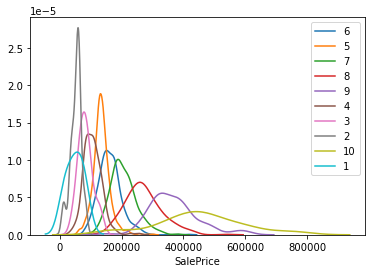

In [243]:
# lets check if they hold some usefull information
categories = 'Overall Qual'
price = 'SalePrice'

for i in df[categories].unique():
    sns.distplot(df[df[categories]==i][price], hist=False, label=i)

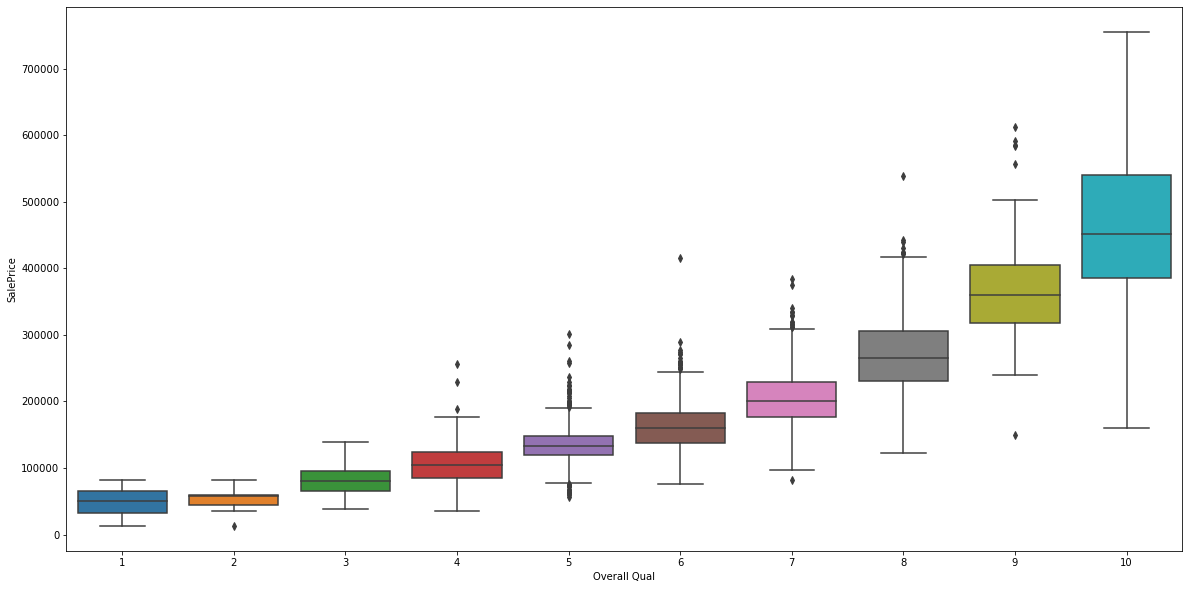

In [244]:
# boxplots
x = 'Overall Qual'
plt.figure(figsize=(20,10))
sns.boxplot(x=x,y='SalePrice',data=df)
plt.show()

In [245]:
# we can check it by statistical testing

F, p = stats.f_oneway(df['SalePrice'], df['Overall Qual'])
result = "correlated" if p < 0.05 else "non-correlated"
print("variables are {}, p-value: {}".format(result, p))

variables are correlated, p-value: 0.0


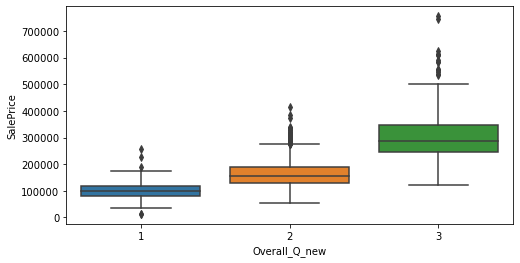

In [246]:
# We can squish the 10 categories in to just two 
d = {1:[1,2,3,4], 2:[5,6,7], 3:[8,9,10]}
d_rev = {v:k for k,lst in d.items() for v in lst}

# convert old values to the new ones
df['Overall_Q_new'] = df['Overall Qual'].apply(lambda x: d_rev[x] if x in d_rev.keys() else 0)
df = df.drop(['Overall Qual'], axis=1)

# check boxplots once again
x = 'Overall_Q_new'
plt.figure(figsize=(8,4))
sns.boxplot(x=x,y='SalePrice',data=df)
plt.show()

In [247]:
# convert the data into numerical columns

dummies = pd.get_dummies(df["Overall_Q_new"], 
                       prefix="OQ",drop_first=True)
df = pd.concat([df, dummies], axis=1)
df = df.drop("Overall_Q_new", axis=1)

df.filter(like="OQ_",axis=1).head()

,OQ_2,OQ_3
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


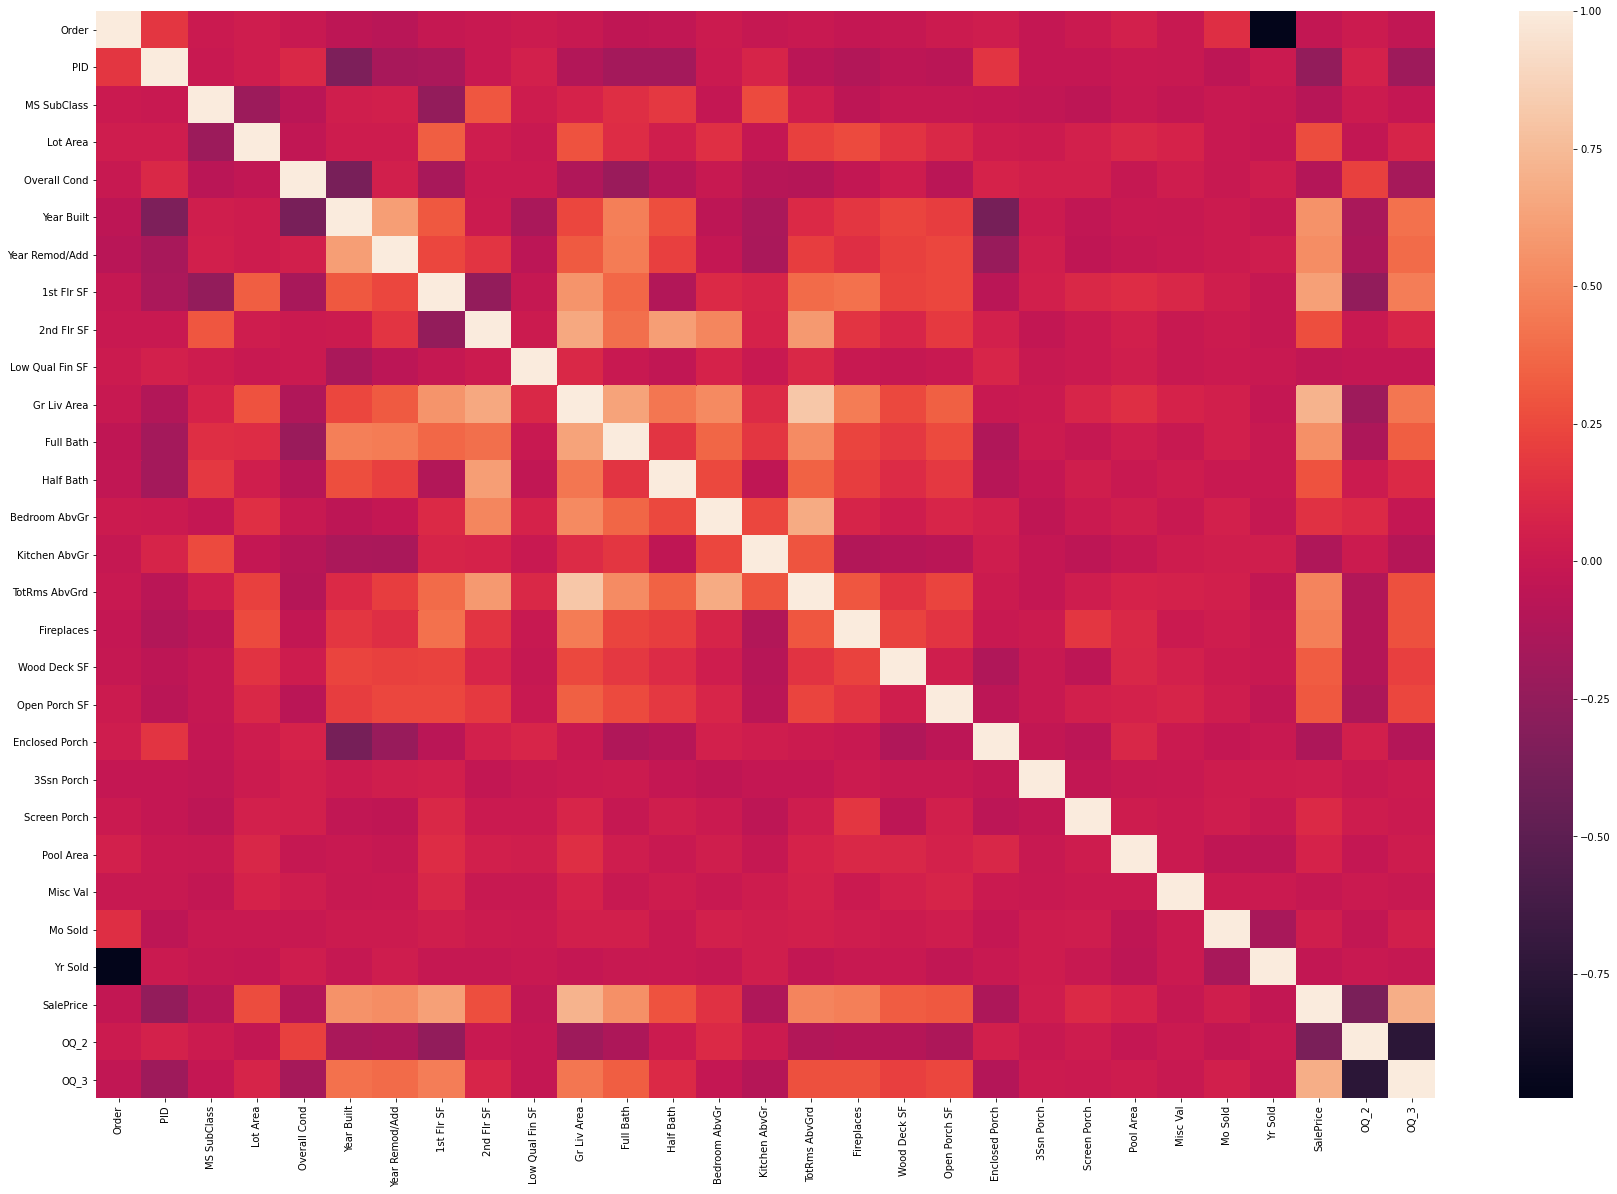

In [248]:
# columns correlation
plt.figure(figsize=(30,20))
sns.heatmap(df.corr())
plt.show()

In [287]:
# let's get rid of the columns that are not correlated with the SalePrice
# method number one

correlation = df.corr()
keep = correlation[correlation['SalePrice']>0.3].index
df = df[keep]
print('rows, columns', df.shape)
df.head()

rows, columns (2930, 11)


,Overall Qual,Year Built,Year Remod/Add,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Wood Deck SF,Open Porch SF,SalePrice
0,6,1960,1960,1656,1656,1,7,2,210,62,215000
1,5,1961,1961,896,896,1,5,0,140,0,105000
2,6,1958,1958,1329,1329,1,6,0,393,36,172000
3,7,1968,1968,2110,2110,2,8,2,0,0,244000
4,5,1997,1998,928,1629,2,6,1,212,34,189900


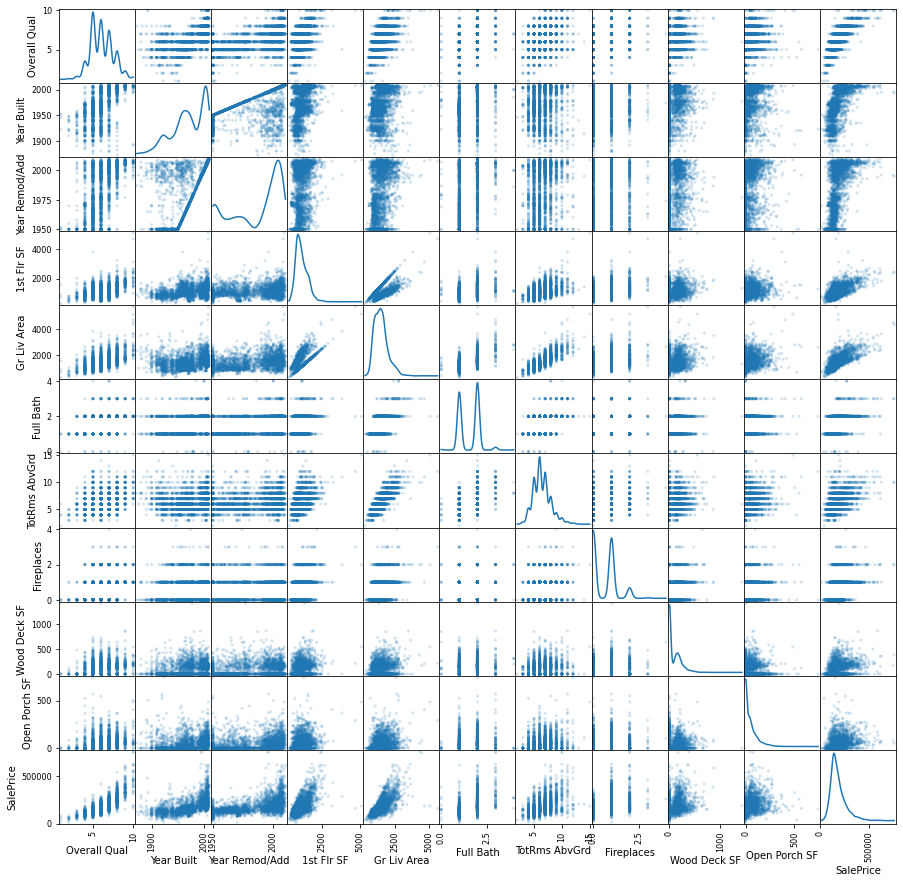

In [288]:
scat_mat_plot = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

C:\Users\kamcl\Miniconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.58497e-21): result may not be accurate.
  overwrite_a=True).T


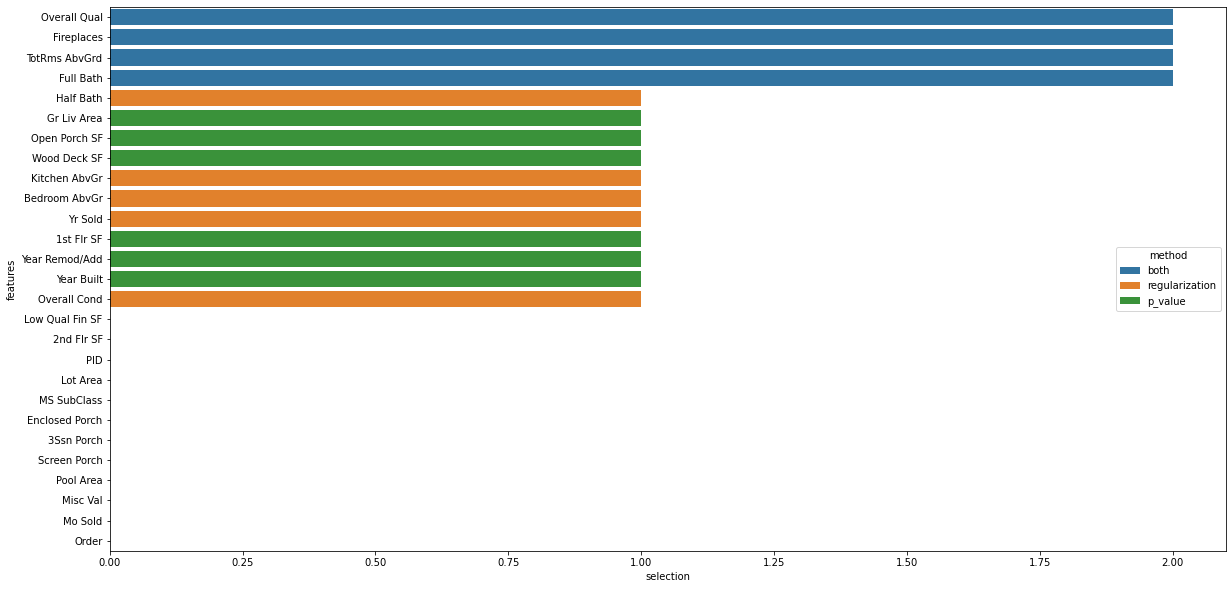

In [266]:
# method number two

plt.figure(figsize=(20,10))

X = df_num.drop('SalePrice', axis=1).values
y = df.SalePrice.values
feature_names = df_num.drop('SalePrice', axis=1).columns

selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=10).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=15).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]


## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

In [267]:
feature_names

Index(['Order', 'PID', 'MS SubClass', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold',
       'Yr Sold'],
      dtype='object')

In [268]:
keep = ['Overall Qual', 'Fireplaces', 'TotRms AbvGrd', 'Full Bath',
        'Gr Liv Area', 'Open Porch SF', 'Wood Deck SF', 'Kitchen AbvGr',
        'Bedroom AbvGr', 'Yr Sold', 'Overall Cond']

# Sale Price distribution

Text(0.5, 1.0, 'Normal distribution')

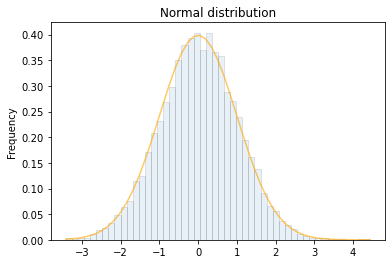

In [67]:
# SalePrice distribution

# normaly distributed data, https://en.wikipedia.org/wiki/Normal_distribution
mu = 0
sigma = 1
n_bins = 50
s = np.random.normal(mu, sigma, 10000)

# plotting
n, bins, patches = plt.hist(s, n_bins, density=True, alpha=.1, edgecolor='black')
pdf = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(bins-mu)**2/(2*sigma**2))
plot = plt.plot(bins, pdf, color='orange', alpha=.6)
plt.ylabel('Frequency')
plt.title('Normal distribution')

Text(0.5, 1.0, 'Sale Price distribution')

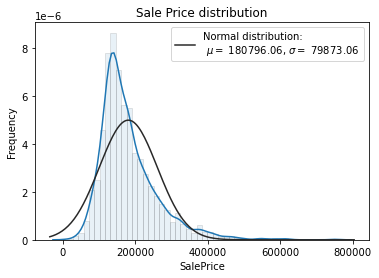

In [73]:
mu, sigma = norm.fit(df['SalePrice'])
sns.distplot(df['SalePrice'] , fit=norm,  hist_kws={'alpha':.1, 'edgecolor':'black'})
plt.legend(['Normal distribution: \n $\mu=$ {:.2f}, $\sigma=$ {:.2f} '.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

# Explanatory variables distributions

In [270]:
df_exp = df_num[keep]
df_exp

,Overall Qual,Fireplaces,TotRms AbvGrd,Full Bath,Gr Liv Area,Open Porch SF,Wood Deck SF,Kitchen AbvGr,Bedroom AbvGr,Yr Sold,Overall Cond
0,6,2,7,1,1656,62,210,1,3,2010,5
1,5,0,5,1,896,0,140,1,2,2010,6
2,6,0,6,1,1329,36,393,1,3,2010,6
3,7,2,8,2,2110,0,0,1,3,2010,5
4,5,1,6,2,1629,34,212,1,3,2010,5
...,...,...,...,...,...,...,...,...,...,...,...
2925,6,0,6,1,1003,0,120,1,3,2006,6
2926,5,0,5,1,902,0,164,1,2,2006,5
2927,5,0,6,1,970,32,80,1,3,2006,5
2928,5,1,6,1,1389,38,240,1,2,2006,5


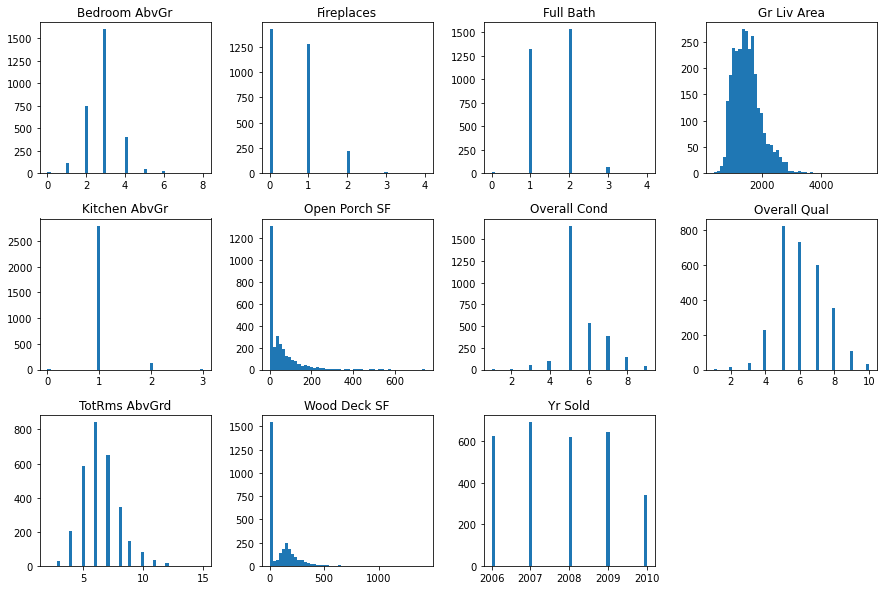

In [289]:
hist_plot = df_exp.hist(layout=(3,4), figsize=(15,10), bins=50, grid=False)
plt.show()